## Amirhossein Kargaran Khouzani (stu no: 99201119)

## Import libraries

In [1]:
from sklearn import datasets
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import gif
import seaborn as sns
np.random.seed(5)

## Part 1 : load dataset

In [2]:
iris = datasets.load_iris()
x = iris.data
y = iris.target

## Part 2: analysis data

In [3]:
iris_df = pd.DataFrame(x, columns = iris.feature_names)
iris_df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3


In [4]:
iris_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
dtypes: float64(4)
memory usage: 4.8 KB


In [5]:
iris_df.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [6]:
iris_df.corr()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
sepal length (cm),1.000000,-0.117570,0.871754,0.817941
sepal width (cm),-0.117570,1.000000,-0.428440,-0.366126
petal length (cm),0.871754,-0.428440,1.000000,0.962865
petal width (cm),0.817941,-0.366126,0.962865,1.000000


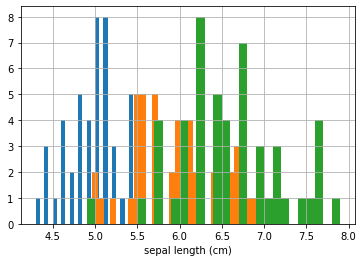

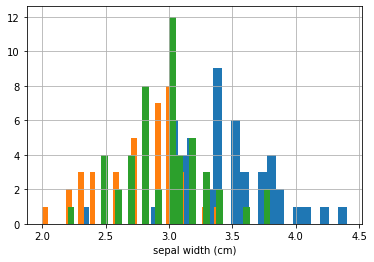

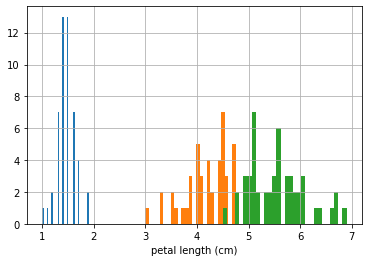

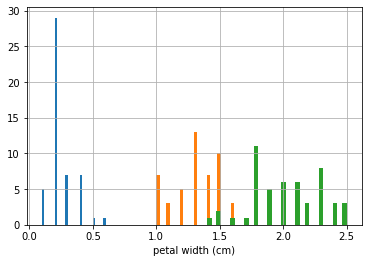

In [7]:
num_fig = 0
for i in list(iris_df.columns):
    num_fig +=1
    for class_number in np.unique(iris.target):
        plt.figure(num_fig)
        plt.xlabel(i)
        iris_df[i].iloc[np.where(iris.target == class_number)[0]].hist(bins=30)

## Part 3: Correlation Matrix

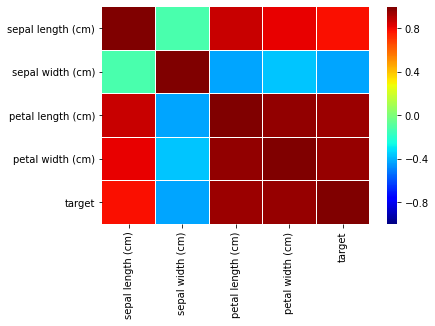

In [8]:
iris_df['target'] = y
correlation = iris_df.corr()
ax = sns.heatmap(correlation, vmin=-1, vmax=1, linewidth=0.01, center=0, cmap='jet')
plt.show()

## Part 4: Kmeans

In [9]:
def kmeans_scratch(dataset, k, iter_count, tresh):
    
    # shuffle data and randomly select k elements as centroids
    centroids = dataset.copy()
    np.random.shuffle(centroids)
    centroids = centroids[:k]
    
    # create empty lists to store loss, ...
    loss_list = []
    last_loss = np.inf
    list_centroids = []
    list_c_set = []

    # for on iter_count
    for i in range(iter_count):
        
        # assign each point to nearest centroid using euclidean distance measure
        distances = np.sqrt(((dataset - centroids.reshape(k,1,centroids.shape[1]))**2).sum(axis=2))
        c_set = np.argmin(distances, axis=0)
        # update centroids
        centroids = np.array([dataset[c_set==i].mean(axis=0) for i in range(k)])

        # save to plot animation
        list_centroids.append(centroids)
        list_c_set.append(c_set)
        
        # compute loss and check difference of last losses with tresh
        loss = 0
        for i in range(k):
            for point in dataset[(c_set == i)]:
                loss += sum((point - centroids[i]) **2)
                
        # add loss to the end of losses sequence
        loss_list.append(loss)
        if abs(last_loss - loss) < tresh:
            break;
        last_loss = loss
        
    return centroids, c_set, loss_list, list_centroids, list_c_set

## Part 5: run kmeans Scratch and Sckit Learn

### Set number of clusters

In [10]:
number_of_clusters = 3

### Run Kmeans Scratch

In [11]:
centroids, clusters, losses_sequence, centroids_sequence, clusters_sequence = kmeans_scratch(x, number_of_clusters, 10, 0.05)

### Run Kmeans Scikit Learn

In [12]:
model = KMeans(n_clusters=number_of_clusters)
model.fit(x)
labels = model.labels_

### Hungarian (Munkres) algorithm to reordering cluster numbers for correct correspondence

- source: https://gist.github.com/siolag161/dc6e42b64e1bde1f263b


In [13]:
!pip install munkres

In [14]:
from munkres import Munkres

def make_cost_matrix(c1, c2):
    """
    """
    uc1 = np.unique(c1)
    uc2 = np.unique(c2)
    l1 = uc1.size
    l2 = uc2.size
    assert(l1 == l2 and np.all(uc1 == uc2))

    m = np.ones([l1, l2])
    for i in range(l1):
        it_i = np.nonzero(c1 == uc1[i])[0]
        for j in range(l2):
            it_j = np.nonzero(c2 == uc2[j])[0]
            m_ij = np.intersect1d(it_j, it_i)
            m[i,j] =  -m_ij.size
    return m

def translate_clustering(clt, mapper):
    return np.array([ mapper[i] for i in clt ])

cost_matrix_scikit = make_cost_matrix(labels, y)
cost_matrix_scratch = make_cost_matrix(clusters, y)

m_scikit = Munkres()
indexes_scikit = m_scikit.compute(cost_matrix_scikit)
mapper_scikit = { old: new for (old, new) in indexes_scikit}
new_labels_scikit = translate_clustering(labels, mapper_scikit)


m_scratch = Munkres()
indexes_scratch = m_scikit.compute(cost_matrix_scratch)
mapper_scratch = { old: new for (old, new) in indexes_scratch}
new_labels_scratch = translate_clustering(clusters, mapper_scratch)

## Part 6: Plot Ground-Truth, Scratch and Scikit-Learn

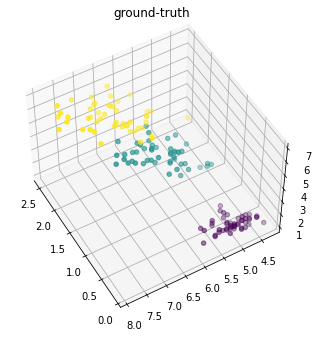

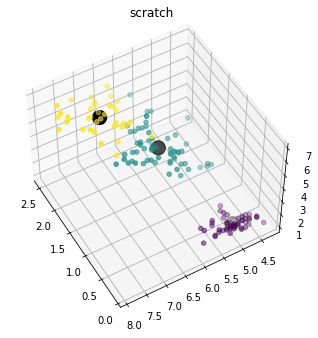

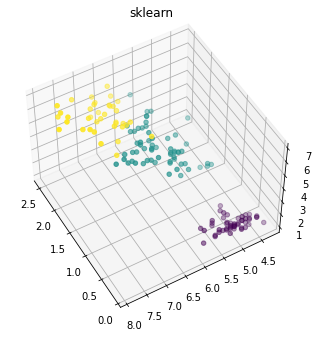

In [15]:
figures = {1: 'ground-truth', 2:'scratch', 3:'sklearn'}
labels_dict = {1: y, 2:new_labels_scratch, 3:new_labels_scikit}
for n in figures.keys():
    fig = plt.figure(num = n, figsize = (4, 4))
    ax = Axes3D(fig, rect=[0, 0, 1, 1], elev=50, azim=150)
    ax.scatter(x[:, 3], x[:, 0], x[:, 2], c = labels_dict[n].astype(float))
    if n == 2:
        # black centroids with bigger point sizes 
        ax.scatter(centroids[:, 3], centroids[:, 0], centroids[:, 2], s = 200, c='black')
    ax.set_title(figures[n])


## Part 7: Counfusion Matrix

In [16]:
def confusion_matrix_scartch(y_true, y_pred):
    num_classes = len(np.unique(y_true))
    matrix = np.zeros((num_classes, num_classes))
    for i in range(len(y_true)):
        matrix[y_true[i]][y_pred[i]] += 1
    return matrix

In [17]:
c_matrix1 = confusion_matrix_scartch(y, new_labels_scratch)
c_matrix1

array([[50.,  0.,  0.],
       [ 0., 48.,  2.],
       [ 0., 14., 36.]])

## Part 8: Kappa Score, Precision, Recall, F1-score over scratch labels

wikipedia: https://en.wikipedia.org/wiki/Confusion_matrix , https://en.wikipedia.org/wiki/Cohen's_kappa

$$
\text{Accuracy (ACC)} = \frac{Σ \text{True positive} + Σ \text{True negative}}{Σ \text{Total population}} = \frac{TP+TN}{TP+TN+FP+FN}
$$


$$
\text{Precision} = \frac{Σ \text{True positive}}{Σ \text{Predicted condition positive}} = \frac{TP}{TP+ FP}
$$

$$
\text{Recall} = \frac{Σ \text{True positive}}{Σ \text{condition positive}} = \frac{TP}{TP+ TN}
$$



$$
\text{F1 score} = 2 \frac{\text{Precision} · \text{Recall}}{\text{Precision} + \text{Recall}} 
$$

$$
\text{Kappa} = \frac{\text{observed accuracy} - \text{expected accuracy}}{1 - \text{expected accuracy}}
$$

In [18]:
print(f" accuracy is : {c_matrix1.trace()/c_matrix1.sum()}")

for i in range(number_of_clusters):
    print(f" Precision of class {i} is : {c_matrix1[i, i] / c_matrix1[:, i].sum()}")
    
for i in range(number_of_clusters):
    print(f" Recall of class {i} is : {c_matrix1[i, i] / c_matrix1[i,:].sum()}")
    
for i in range(number_of_clusters):
    print(f" F1 score of class {i} is : {2 * c_matrix1[i, i] / (c_matrix1[:, i].sum() + c_matrix1[i,:].sum())}")

 accuracy is : 0.8933333333333333
 Precision of class 0 is : 1.0
 Precision of class 1 is : 0.7741935483870968
 Precision of class 2 is : 0.9473684210526315
 Recall of class 0 is : 1.0
 Recall of class 1 is : 0.96
 Recall of class 2 is : 0.72
 F1 score of class 0 is : 1.0
 F1 score of class 1 is : 0.8571428571428571
 F1 score of class 2 is : 0.8181818181818182


In [19]:
e = 0
for i in range(number_of_clusters):
    e += np.sum(c_matrix1[i,:]) * np.sum(c_matrix1[:,i])

print(f" Kappa is : {(c_matrix1.trace() * np.sum(c_matrix1) - e)/ (np.sum(c_matrix1)**2 - e)}")

 Kappa is : 0.84


## Part 9: Kappa Score, Precision, Recall, F1-score, Confusion Matrix over Sckit Learn labels

In [20]:
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score

c_matrix2 = confusion_matrix(y, new_labels_scikit)

print(f"classification report:\n{classification_report(y, new_labels_scikit)}")
print(f"cohen_kappa_score: {cohen_kappa_score(y, new_labels_scikit)}")
print(f"confusion_matrix:\n{c_matrix2}")

classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       0.77      0.96      0.86        50
           2       0.95      0.72      0.82        50

    accuracy                           0.89       150
   macro avg       0.91      0.89      0.89       150
weighted avg       0.91      0.89      0.89       150

cohen_kappa_score: 0.84
confusion_matrix:
[[50  0  0]
 [ 0 48  2]
 [ 0 14 36]]


### Compare part 8,7 with 9 : both are equal 

## Part 10: loss plot + upper and lower threshold bound as horizintal lines

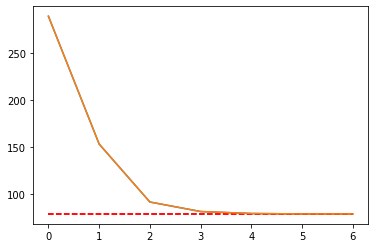

In [21]:
plt.plot(losses_sequence)
horiz_line_u = [losses_sequence[-1]]*len(losses_sequence)
horiz_line_l = [losses_sequence[-2]]*len(losses_sequence)

plt.plot(horiz_line_u, 'r--') 
plt.plot(horiz_line_l, 'r--')
plt.plot(losses_sequence)
plt.show()

## Part 11: gif kmeans plot

In [22]:
%matplotlib inline

gif.options.matplotlib["dpi"] = 300

@gif.frame
def plot(i):
    centroids_sequence_i = centroids_sequence[i]
    clusters_sequence_i = clusters_sequence[i]
    
    plt.scatter(x[:, 0], x[:, 1], c = clusters_sequence_i)
    plt.scatter(centroids_sequence_i[:, 0], centroids_sequence_i[:, 1], c='black', s=100)

frames = []
for i in range(len(centroids_sequence)):
    frame = plot(i)
    frames.append(frame)

gif.save(frames, 'q1-part9.gif', duration=len(centroids_sequence), unit="s", between="startend")

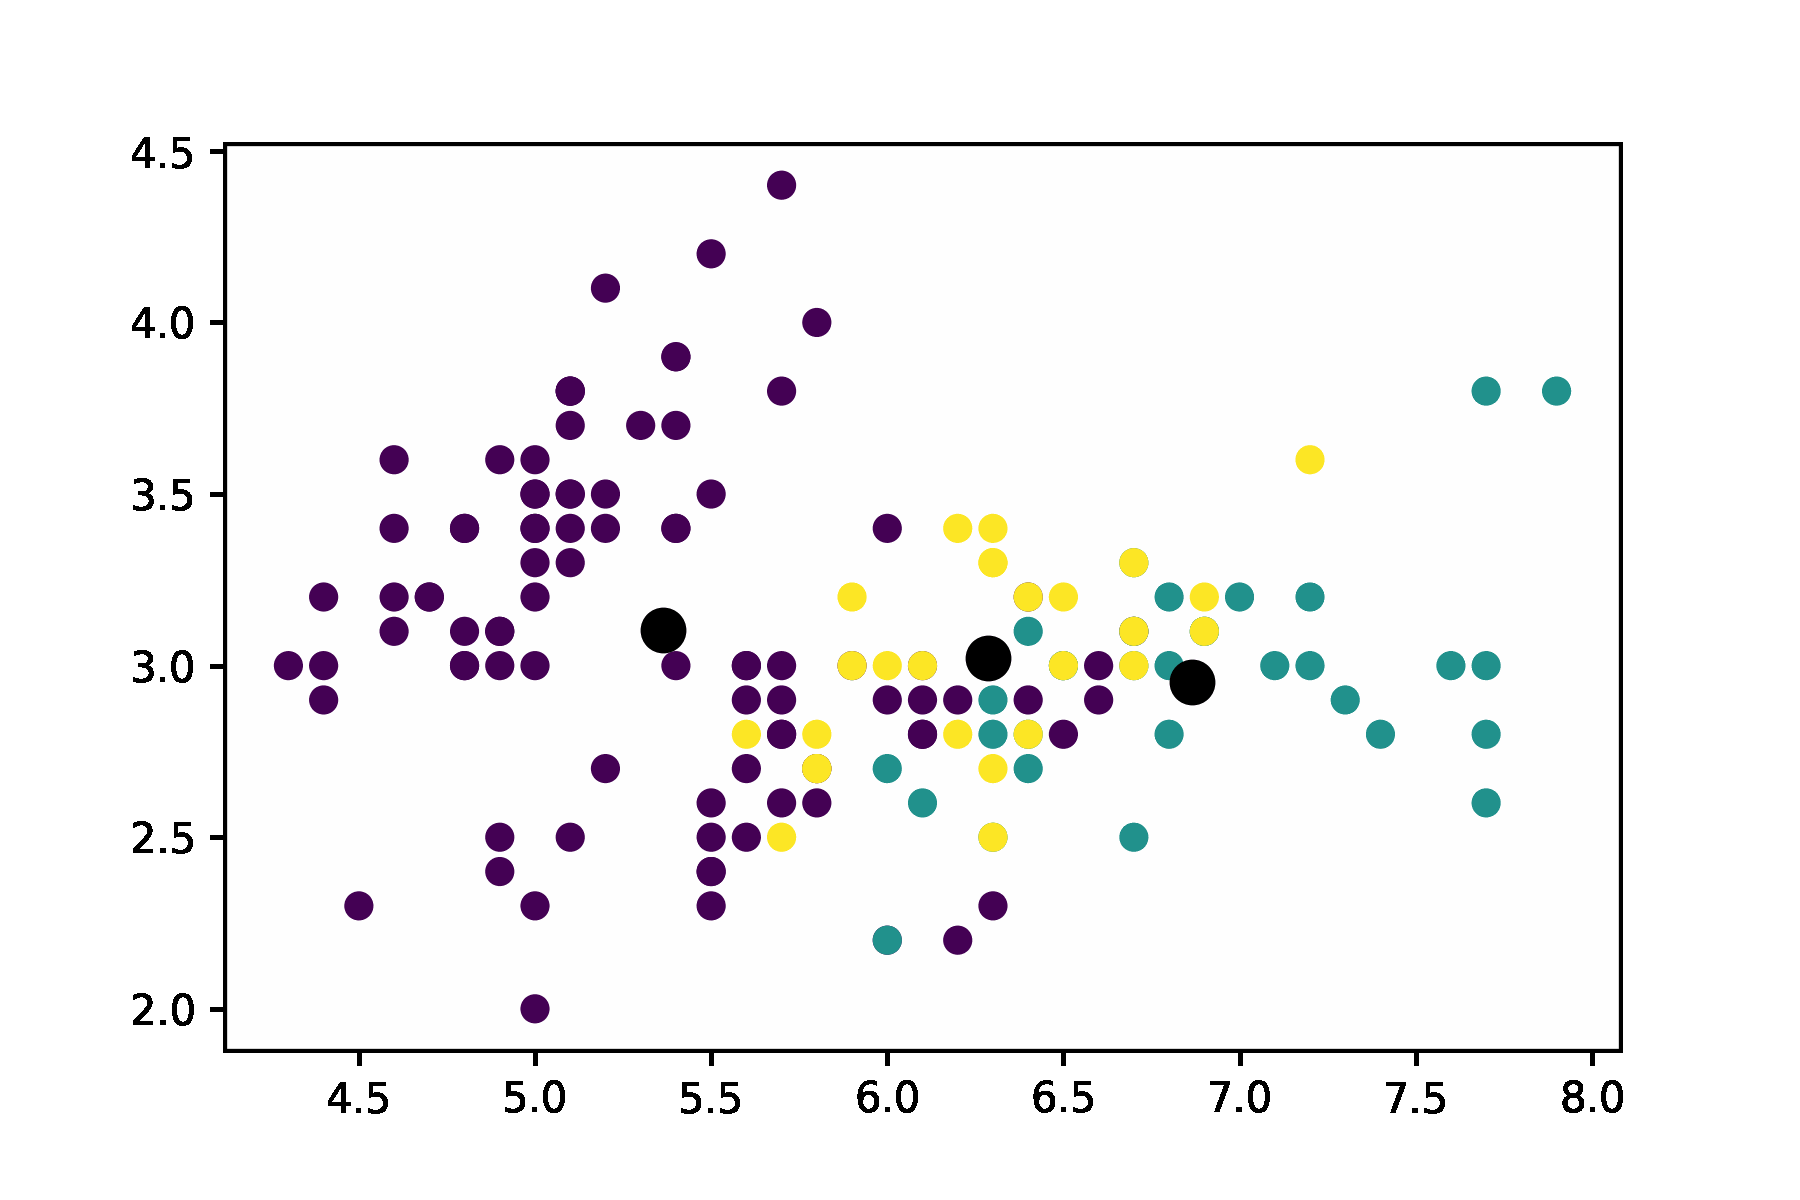